In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#root_dir = '/content/gdrive/MyDrive/Data'

root_dir = '../../../Data'

Mounted at /content/gdrive


In [3]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep

In [4]:
experience = 1

number_columns = 5
#number_columns = 3
#number_columns = 2

def construct_training_labels(number_columns, labels):
  n = labels.shape[0]
  training_labels = np.zeros((n,number_columns))
  for i in range(n):
    training_labels[i][labels[i]] = 1
  return training_labels

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_wake(val):
  arr = {'N1':0, 'N2':0, 'N3':0, 'REM':0, 'Wake':1, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_pos(val):
  arr = {'Supine;':0, 'Upright;':1, 'Right;':2, 'Prone;':3, 'Left;':4, 'Artefact;':np.NaN, 'A;':np.NaN}
  return arr[val]

def encode_sleep_hr(val):
  if val == 'A;':
    return np.NaN
  n = len(val)
  val = int(val[:n-1])
  if (val < 60):
    return 0
  if (val < 100 and val >= 60):
    return 1
  return 2

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))

file_name = os.path.join(features_dir, "RawUnlabelled")
#file_name = os.path.join(features_dir, "UnlabelledHR")
#file_name = os.path.join(features_dir, "UnlabelledPOS")

unlabelled_dataset = pd.read_pickle(file_name)

file_name_stage = os.path.join(features_dir, "RawLabelled")
file_name_hr = os.path.join(features_dir, "RawLabelledHR")
file_name_pos = os.path.join(features_dir, "RawLabelledPOS")

labelled_dataset_stage = pd.read_pickle(file_name_stage)
labelled_dataset_wake = pd.read_pickle(file_name_stage)
labelled_dataset_hr = pd.read_pickle(file_name_hr)
labelled_dataset_pos = pd.read_pickle(file_name_pos)

OnLabel = ["Label", 'X1', 'X2', 'Y1', 'Y2', 'Z1', 'Z2', 'Temp','Activity', 'Sleep State']

print(labelled_dataset_pos.head(1))

new_labelled_dataset = pd.merge(labelled_dataset_stage, labelled_dataset_pos, on=OnLabel)
merged_test_dataset = pd.merge(new_labelled_dataset, labelled_dataset_hr, on=OnLabel)
merged_test_dataset['Sleep Wake'] = merged_test_dataset['Sleep State']

#print(new_labelled_dataset)

labels_stage = merged_test_dataset['Sleep State']
labels_wake = merged_test_dataset['Sleep Wake']
labels_pos = merged_test_dataset['Value_x']
labels_hr = merged_test_dataset['Value_y']

#print(labels_stage.unique())
#print(labels_wake.unique())
#print(labels_pos.unique())
#print(labels_hr.unique())
#print(unlabelled_dataset.shape)

save_sleep_labels_sleep_stage = os.path.join(features_dir, "RawSleepStageLabels.npy")
save_sleep_labels_sleep_wake = os.path.join(features_dir, "RawSleepWakeLabels.npy")
save_sleep_labels_sleep_pos = os.path.join(features_dir, "RawSleepPosLabels.npy")
save_sleep_labels_sleep_hr = os.path.join(features_dir, "RawSleepHRLabels.npy")

y_labels_stage = np.load(save_sleep_labels_sleep_stage)
y_labels_wake = np.load(save_sleep_labels_sleep_wake)
y_labels_pos = np.load(save_sleep_labels_sleep_pos)
y_labels_hr = np.load(save_sleep_labels_sleep_hr)

print(y_labels_stage[:1000])

merged_test_dataset['Sleep State'] = merged_test_dataset['Sleep State'].apply(lambda x: encode_sleep_stage(x))
merged_test_dataset['Sleep State'] = pd.Series(np.array(merged_test_dataset['Sleep State'])).interpolate()
merged_test_dataset['Sleep State'] = np.array(merged_test_dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)

merged_test_dataset['Sleep Wake'] = merged_test_dataset['Sleep Wake'].apply(lambda x: encode_sleep_wake(x))
merged_test_dataset['Sleep Wake'] = pd.Series(np.array(merged_test_dataset['Sleep Wake'])).interpolate()
merged_test_dataset['Sleep Wake'] = np.array(merged_test_dataset['Sleep Wake'].replace(to_replace = np.nan, value=4), dtype=np.int64)

merged_test_dataset['Value_x'] = merged_test_dataset['Value_x'].apply(lambda x: encode_sleep_pos(x))
#print(dataset['Value'].unique())
merged_test_dataset['Value_x'] = pd.Series(np.array(merged_test_dataset['Value_x'])).interpolate()
merged_test_dataset['Value_x'] = merged_test_dataset['Value_x'].apply(lambda x: int(x))

merged_test_dataset['Value_y'] = merged_test_dataset['Value_y'].apply(lambda x: encode_sleep_hr(x))
merged_test_dataset['Value_y'] = pd.Series(np.array(merged_test_dataset['Value_y'])).interpolate()
merged_test_dataset['Value_y'] = merged_test_dataset['Value_y'].apply(lambda x: int(x))

y_labels_stage_values = np.array(merged_test_dataset['Sleep State'])
y_labels_wake_values = np.array(merged_test_dataset['Sleep Wake'])
y_labels_pos_values = np.array(merged_test_dataset['Value_x'])
y_labels_hr_values = np.array(merged_test_dataset['Value_y'])

y_test_stage = construct_training_labels(5, y_labels_stage_values)
y_test_wake = construct_training_labels(2, y_labels_wake_values)
y_test_pos = construct_training_labels(5, y_labels_pos_values)
y_test_hr = construct_training_labels(3, y_labels_hr_values)

y_train_stage = construct_training_labels(5, y_labels_stage)
y_train_wake = construct_training_labels(2, y_labels_wake)
y_train_pos = construct_training_labels(5, y_labels_pos)
y_train_hr = construct_training_labels(3, y_labels_hr)

x_test = np.array(merged_test_dataset.drop(['Label','Sleep State', 'Sleep Wake', 'Value_x', 'Value_y'], axis=1))
x_train = np.array(unlabelled_dataset.drop(['Label','Sleep State'], axis=1))

def split_trains_sets(train_set, split_ratio):
  n = train_set.shape[0]
  split_point = int(split_ratio * n)
  split_train_1 = train_set[:split_point]
  split_train_2 = train_set[split_point:]
  return split_train_1, split_train_2

train_split_ratio = 0.75

y_train_stage, additional_stage = split_trains_sets(y_train_stage, train_split_ratio)
y_train_wake, additional_wake = split_trains_sets(y_train_wake, train_split_ratio)
y_train_pos, additional_pos = split_trains_sets(y_train_pos, train_split_ratio)
y_train_hr, additional_hr = split_trains_sets(y_train_hr, train_split_ratio)

x_train, additional_train = split_trains_sets(x_train, train_split_ratio)

train_split_ratio = 0.9

y_test_stage, additional_test_stage = split_trains_sets(y_test_stage, train_split_ratio)
y_test_wake, additional_test_wake = split_trains_sets(y_test_wake, train_split_ratio)
y_test_pos, additional_test_pos = split_trains_sets(y_test_pos, train_split_ratio)
y_test_hr, additional_test_hr = split_trains_sets(y_test_hr, train_split_ratio)

x_test, additional_test = split_trains_sets(x_test, train_split_ratio)

y_test_stage = np.append(y_test_stage, additional_stage, axis=0)
y_test_wake = np.append(y_test_wake, additional_wake, axis=0)
y_test_pos = np.append(y_test_pos, additional_pos, axis=0)
y_test_hr = np.append(y_test_hr, additional_hr, axis=0)

x_test = np.append(x_test, additional_train, axis=0)

train_split_ratio = 0.9

y_train_stage, y_test_stage_f = split_trains_sets(y_train_stage, train_split_ratio)
y_train_wake, y_test_wake_f = split_trains_sets(y_train_wake, train_split_ratio)
y_train_pos, y_test_pos_f = split_trains_sets(y_train_pos, train_split_ratio)
y_train_hr, y_test_hr_f = split_trains_sets(y_train_hr, train_split_ratio)

x_train, x_test_f = split_trains_sets(x_train, train_split_ratio)

#Creating test sets
y_test_stage_f = np.append(y_test_stage_f, additional_test_stage, axis=0)
y_test_wake_f = np.append(y_test_wake_f, additional_test_wake, axis=0)
y_test_pos_f = np.append(y_test_pos_f, additional_test_pos, axis=0)
y_test_hr_f = np.append(y_test_hr_f, additional_test_hr, axis=0)

x_test_f = np.append(x_test_f, additional_test, axis=0)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1, 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1, 1))
x_test_f = x_test_f.reshape((x_test_f.shape[0], x_test_f.shape[1], 1, 1))

print(x_test.shape)
print(x_train.shape)
print(x_test_f.shape)
print(x_test.shape)
print(x_train.shape)

print(y_test_stage)

                 Label        X1        X2        Y1        Y2        Z1  \
0  2020-02-12 22:15:30 -0.521875 -0.522604 -0.078323 -0.085365  0.813146   

        Z2   Temp  Activity    Value Sleep State  
0  0.81325  266.0      51.0  Supine;        Wake  
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4
 1 1 1 1 2 2 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

Multi-task

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8, 1, 1)]    0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 8, 1, 8)      16          ['input[0][0]']                  
                                                                                                  
 act_1 (Activation)             (None, 8, 1, 8)      0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 8, 1, 4)      36          ['act_1[0][0]']                  
                                                                                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


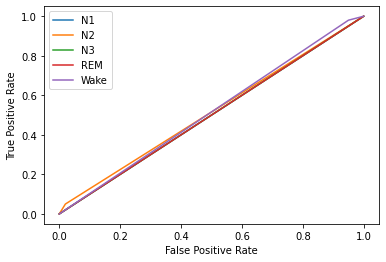

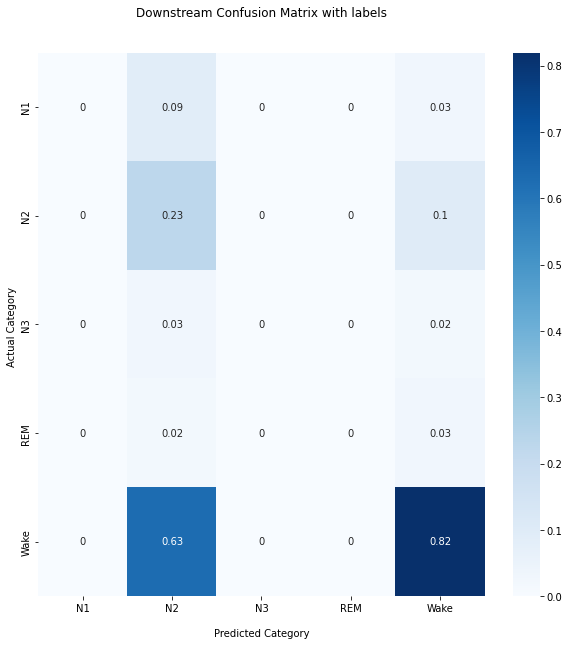

[[24386 12197]
 [10143 94637]]
Precision, Recall and F1 Score for Sleep are 0.71, 0.67, 0.69
Precision, Recall and F1 Score for Wake are 0.89, 0.9, 0.89
(2, 2)
Accuracy is 0.84
Performance is 0.79


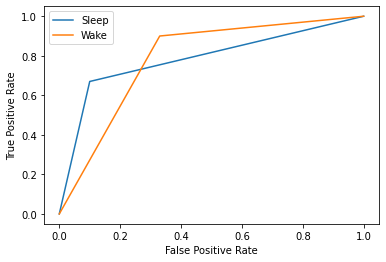

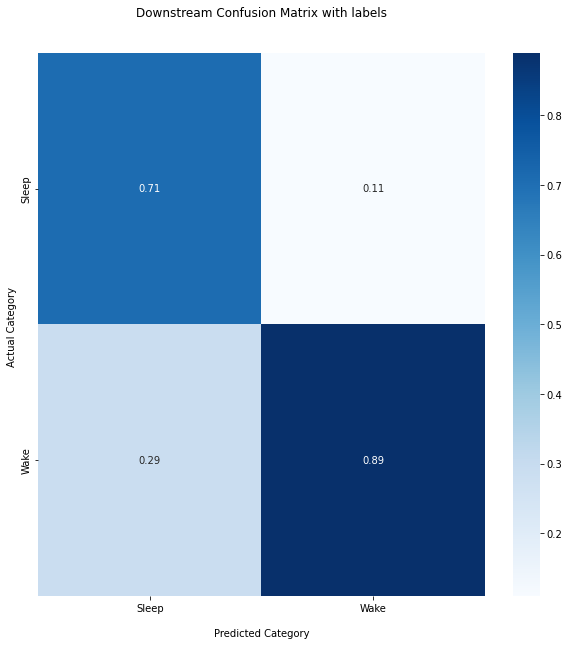

[[44542  1501  5175     0  1610]
 [ 2124 31891   667     0     0]
 [ 2783  3701 33128     0    22]
 [  298   143   296     0   314]
 [ 6186    85  1875     0  5022]]
Precision, Recall and F1 Score for Supine are 0.8, 0.84, 0.82
Precision, Recall and F1 Score for Upright are 0.85, 0.92, 0.88
Precision, Recall and F1 Score for Right are 0.81, 0.84, 0.82
Precision, Recall and F1 Score for Prone are nan, 0.0, nan
Precision, Recall and F1 Score for Left are 0.72, 0.38, 0.5
(5, 5)
Accuracy is 0.81
Performance is nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


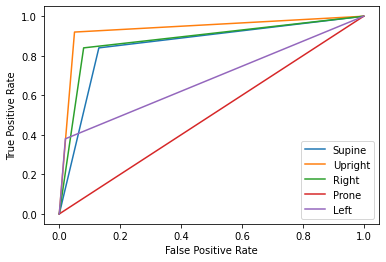

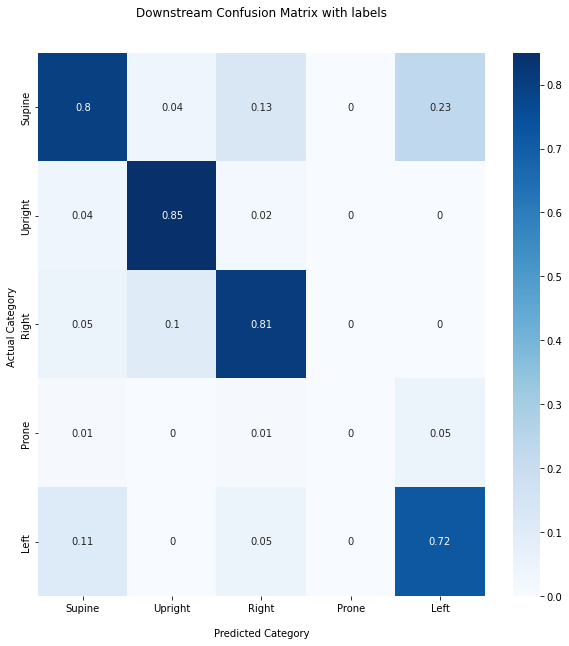

[[  6115  15738      0]
 [  3462 115776      0]
 [    26    246      0]]
Precision, Recall and F1 Score for Slow are 0.64, 0.28, 0.39
Precision, Recall and F1 Score for Normal are 0.88, 0.97, 0.92
Precision, Recall and F1 Score for Fast are nan, 0.0, nan
(3, 3)
Accuracy is 0.86
Performance is nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


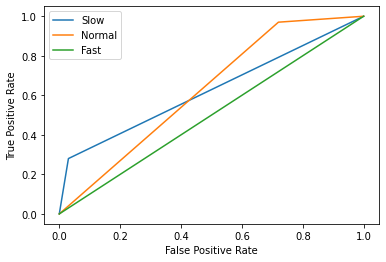

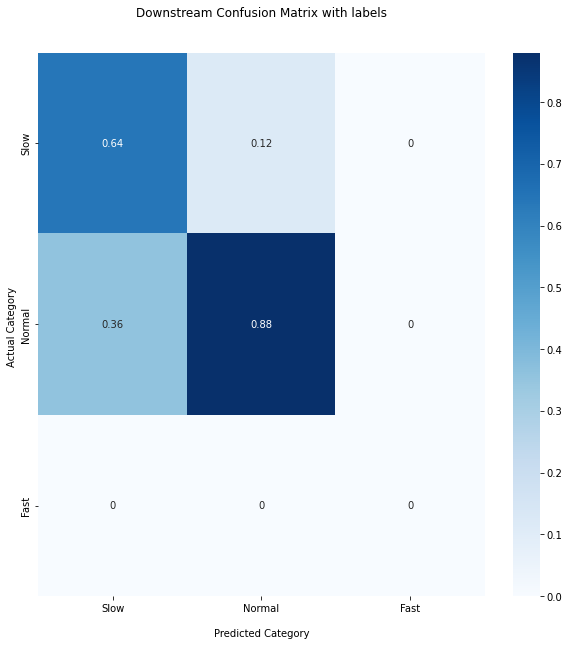

([0.64, 0.88, nan], 0.86)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

input_ = Input(shape=(x_train.shape[1],1,1), name='input')

conv_1 = Conv2D(8, 1, name='conv_1')(input_)
act_1 = Activation('relu', name='act_1')(conv_1)

conv_2 = Conv2D(4, 1, name='conv_2')(act_1)
act_2 = Activation('relu', name='act_2')(conv_2)

flat_1 = Flatten(name='flat_1')(act_2)

sleep_stage_dense_1 = Dense(10, activation='sigmoid', name='sleep_stage_dense_1')(flat_1)
sleep_stage_dense_2 = Dense(5, activation='softmax', name='sleep_stage_dense_2')(sleep_stage_dense_1)

sleep_wake_dense_1 = Dense(10, activation='sigmoid', name='sleep_wake_dense_1')(flat_1)
sleep_wake_dense_2 = Dense(2, activation='softmax', name='sleep_wake_dense_2')(sleep_wake_dense_1)

sleep_pos_dense_1 = Dense(10, activation='sigmoid', name='sleep_pos_dense_1')(flat_1)
sleep_pos_dense_2 = Dense(5, activation='softmax', name='sleep_pos_dense_2')(sleep_pos_dense_1)

sleep_hr_dense_1 = Dense(10, activation='sigmoid', name='sleep_hr_dense_1')(flat_1)
sleep_hr_dense_2 = Dense(3, activation='softmax', name='sleep_hr_dense_2')(sleep_hr_dense_1)

model = tf.keras.models.Model(input_, [sleep_stage_dense_2, sleep_wake_dense_2,sleep_pos_dense_2,sleep_hr_dense_2])
model.summary()

model.compile(
    loss={
        'sleep_stage_dense_2': 'categorical_crossentropy',
        'sleep_wake_dense_2': 'binary_crossentropy',
        'sleep_pos_dense_2': 'categorical_crossentropy',
        'sleep_hr_dense_2': 'categorical_crossentropy'
    },
    optimizer='RMSprop',
    metrics=['accuracy']
)

_ = model.fit(x_train, [y_train_stage, y_train_wake, y_train_pos, y_train_hr], validation_data=(x_test, [y_test_stage, y_test_wake, y_test_pos, y_test_hr]), 
              batch_size=128,epochs=100)

y_preds = model.predict(x_test_f)

test_labels = np.argmax(y_test_stage_f, axis=1)
y_pred = np.argmax(y_preds[:][0], axis=1)

Labels = ['N1', 'N2', 'N3', 'REM', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_wake_f, axis=1)
y_pred = np.argmax(y_preds[:][1], axis=1)

Labels = ['Sleep', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_pos_f, axis=1)
y_pred = np.argmax(y_preds[:][2], axis=1)

Labels = ['Supine', 'Upright', 'Right', 'Prone', 'Left']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_hr_f, axis=1)
y_pred = np.argmax(y_preds[:][3], axis=1)

Labels = ['Slow', 'Normal', 'Fast']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)


Sleep stage

In [ ]:
model = Sequential()
model.add(Dense(12, input_shape=(x_train.shape[1],), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()
model.fit(x_train, y_train_stage, validation_data=(x_test, y_test_stage), batch_size=1, epochs=15)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 12)                108       
                                                                 
 dense_18 (Dense)            (None, 8)                 104       
                                                                 
 dense_19 (Dense)            (None, 5)                 45        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
145100/496171 [=======>......................] - ETA: 8:59 - loss: 0.7004 - accuracy: 0.8836

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
#add model layers
model.add(Conv2D(49, kernel_size=(5,1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Conv2D(24, kernel_size=(2,1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer='RMSprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

n= int(x_train.shape[0]/5)
history = model.fit(x_train[:n], y_train_stage[:n], validation_data=(x_test, y_test_stage), batch_size=128, epochs=5)

test_labels = np.argmax(y_test_stage_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['N1', 'N2', 'N3', 'REM', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)


Sleep wake

Epoch 1/15
372128/372128 [==============================] - 829s 2ms/step - loss: 0.4194 - accuracy: 0.8066 - val_loss: 0.5177 - val_accuracy: 0.7413
Epoch 2/15
372128/372128 [==============================] - 759s 2ms/step - loss: 0.4601 - accuracy: 0.7848 - val_loss: 0.6920 - val_accuracy: 0.6784
Epoch 3/15
372128/372128 [==============================] - 770s 2ms/step - loss: 0.4833 - accuracy: 0.7785 - val_loss: 0.5164 - val_accuracy: 0.7442
Epoch 4/15
372128/372128 [==============================] - 764s 2ms/step - loss: 0.4802 - accuracy: 0.7826 - val_loss: 0.6299 - val_accuracy: 0.7177
Epoch 5/15
372128/372128 [==============================] - 759s 2ms/step - loss: 0.4962 - accuracy: 0.7851 - val_loss: 0.5198 - val_accuracy: 0.7352
Epoch 6/15
372128/372128 [==============================] - 749s 2ms/step - loss: 0.4937 - accuracy: 0.7902 - val_loss: 0.4882 - val_accuracy: 0.7343
Epoch 7/15
372128/372128 [==============================] - 752s 2ms/step - loss: 0.4976 - accuracy:

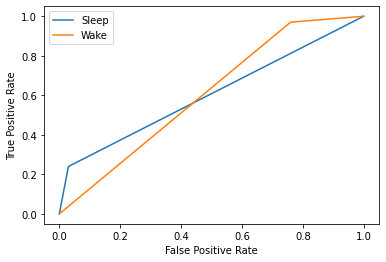

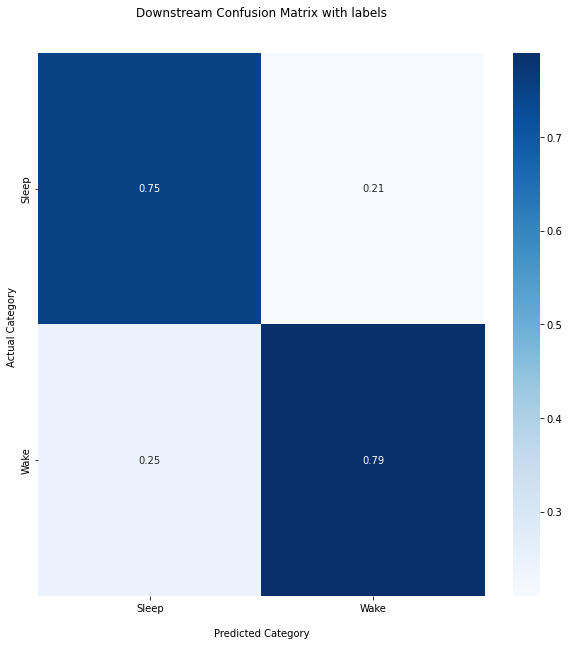

([0.75, 0.79], 0.78)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
#add model layers
model.add(Conv2D(8, kernel_size=(1,1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
model.add(Flatten())
model.add(Dense(7, activation='relu'))
model.add(Dense(2, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train, y_train_wake, validation_data=(x_test, y_test_wake), batch_size=1, epochs=15)

test_labels = np.argmax(y_test_wake_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['Sleep', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep pos

Epoch 1/15
372128/372128 [==============================] - 716s 2ms/step - loss: 0.8032 - accuracy: 0.7472 - val_loss: 1.0181 - val_accuracy: 0.6923
Epoch 2/15
372128/372128 [==============================] - 728s 2ms/step - loss: 0.9327 - accuracy: 0.7107 - val_loss: 1.0560 - val_accuracy: 0.6666
Epoch 3/15
372128/372128 [==============================] - 733s 2ms/step - loss: 0.9747 - accuracy: 0.6945 - val_loss: 1.0485 - val_accuracy: 0.6465
Epoch 4/15
372128/372128 [==============================] - 755s 2ms/step - loss: 0.9690 - accuracy: 0.6975 - val_loss: 1.0364 - val_accuracy: 0.6753
Epoch 5/15
372128/372128 [==============================] - 739s 2ms/step - loss: 0.8874 - accuracy: 0.7102 - val_loss: 1.3899 - val_accuracy: 0.6380
Epoch 6/15
372128/372128 [==============================] - 844s 2ms/step - loss: 0.8551 - accuracy: 0.7224 - val_loss: 0.8783 - val_accuracy: 0.6786
Epoch 7/15
372128/372128 [==============================] - 808s 2ms/step - loss: 0.8824 - accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


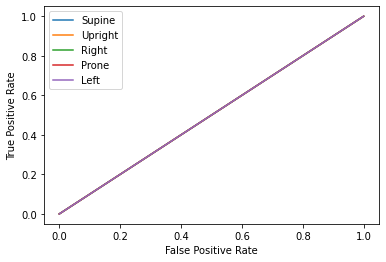

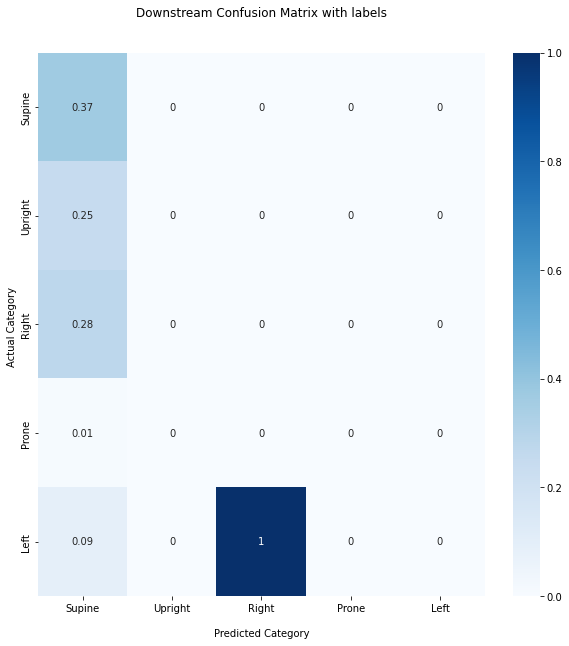

([0.37, nan, 0.0, nan, nan], 0.37)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
#add model layers
model.add(Conv2D(8, kernel_size=(1,1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train, y_train_pos, validation_data=(x_test, y_test_pos), batch_size=1, epochs=15)

test_labels = np.argmax(y_test_pos_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['Supine', 'Upright', 'Right', 'Prone', 'Left']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep hr

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
#add model layers
model.add(Conv2D(8, kernel_size=(1,1), activation='relu', input_shape=(x_train.shape[1], 1, 1)))
model.add(Flatten())
model.add(Dense(7, activation='relu'))
model.add(Dense(3, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train, y_train_hr, validation_data=(x_test, y_test_hr), batch_size=1, epochs=15)

test_labels = np.argmax(y_test_hr_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['Slow', 'Normal', 'Fast']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Confusion

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics

#printConfusionMatrix(y_test, y_pred, Labels, show=True)

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  
  print(cf_matrix)

  precisions = []
  recalls = []
  f1_scores = []
  FPRs = []
  n = len(test_labels)

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)
    f1_scores.append(f1_score)
    
    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)
  performance = round((np.array(f1_scores).sum()+np.array(recalls).sum()+np.array(precisions).sum())/(3*len(Labels)), 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      if (cf_matrix[i][j] == 0):
        cf_mat[i][j] = 0
      else:
        cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    print("Performance is " + str(performance))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Downstream Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

def get_n_rand_nums(start, end, totalNums):
  randIdx = random.sample(range(start, end), totalNums)
  randIdx.sort()
  return randIdx

# divides up the array to two arrays using the ids array
def separateArr(arr, ids):
  ids_id = 0
  part_1 = []
  part_2 = []

  print(arr.shape)

  for i in range(arr.shape[0]):
    row = arr[i]
    if ids_id < len(ids) and i == ids[ids_id]:
      part_2.append(row)
      ids_id += 1
    else:
      part_1.append(row)

  return np.array(part_1), np.array(part_2)